# Introducción a la modelización


## Objetivos

* Tener una introducción a la manera de pensar cuantitativa para resolver problemas de negocio, y ver ejemplos   
* Entender qué es un modelo y saber distinguir estrategias para ayuda de toma de decisiones basadas en criterios manuales y basadas en modelos. Ejercitar esto con ejemplos de problemas variados. 
* Familiarizarse con el vocabulario y conceptos que aparecerán en futuras clases de técnicas más específicas.


## Suposiciones

* Alumnos hasta ahora han tocado programación y manipulación de datos
* Orientado a ejemlos prácticos

## Disclaimer

* Estos notebooks son de apoyo a la clase, tened en cuenta que puede haber contenido de clase como explicaciones de pizarra o ejercicio, por tanto el notebook no es un "log" completo de la clase (aunque sí de una gran parte). 


# Qué es y qué no es un modelo

**La filosofía: decisiones orientadas a datos**

Uno de los propósitos de la ciencia de datos es ofrecer metodologías para ayudar a los negocios a tomar mejores decisiones automáticas a partir de datos. Esto puede suceder de varias maneras

* Tomando una decisión humana pero informada por datos
* Programando un sistema para que tome una decisión automática "estática". 
* Programando un sistema para que tome una decisión automática, y además la propia acción que se toma está derivada del dato. 

Nos interesa la 3a, donde está la clave de la modelización. Pero vamos a ver rápidamente todas. 


## Analítica descriptiva: Estar "informados" para tomar decisiones 

A veces, el simple hecho de capturar datos sobre un proceso de negocios, visualizarlos, y cuantificar cantidades de interés permite entender mejor el impacto de las decisiones. O ahorrar tiempo. Esto se conoce como *analítica descriptiva*.

Por ejemplo, consideremos una serie con el número de pedidos de diferentes productos a una empresa. Usaremos como ejemplo la serie "Daily Demand Forecasting" del repositorio UCI. 

In [11]:
import pandas as pd

URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00409/Daily_Demand_Forecasting_Orders.csv"
frm = pd.read_csv(URL, sep=";", thousands='.')
frm.columns = ['week', 'day', 'urgent', 'nonurgent', 'A', 'B', 'C', 'fiscal', 'traffic', 'bank1', 'bank2', 'bank3', 'total' ]
frm.head()

,week,day,urgent,nonurgent,A,B,C,fiscal,traffic,bank1,bank2,bank3,total
0,1,4,316307,223270,61543,175586,302448,0,65556,44914,188411,14793,539577
1,1,5,128633,96042,38058,56037,130580,0,40419,21399,89461,7679,224675
2,1,6,43651,84375,21826,25125,82461,1386,11992,3452,21305,14947,129412
3,2,2,171297,127667,41542,113294,162284,18156,49971,33703,69054,18423,317120
4,2,3,90532,113526,37679,56618,116220,6459,48534,19646,16411,20257,210517


Pintamos el número total de pedidos por día. 

Text(0, 0.5, 'Demand of all products')

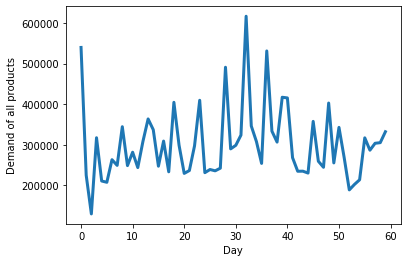

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(frm['total'], linewidth=3)
plt.xlabel('Day')
plt.ylabel('Demand of all products')

¿Nos dice algo informativo esta gráfica? Podemos ver que algunos días tenemos pedidos inusualmente altos, pero poco más. ¿Quizás con una periodicidad? Agrupamos número de pedidos por día:

In [3]:
frm.groupby('day').sum()[['total']]

,total
day,
2,4292364
3,3647181
4,3665064
5,3287619
6,3160171


Podemos ver cómo el número total de pedidos por día es variable, pero que hay picos todos los lunes (2). Esta simple visualización o "query" nos permite decidir que podemos rellenar el stock los viernes para tener preparado todo el material. 

## Analítica con datos... pero sin modelos

Imaginemos ahora que no sólo queremos estar informados o tener una idea general de los pedidos, sino seguir haciendo preguntas más complicadas y tener respuestas basadas en los datos.

Por ejemplo: ¿qué días hemos tenido un número inusual de pedidos de tipo A? (Por ejemplo, queremos analizar qué pasó ese día de cara a entender qué ha funcionado, o planear el aprovisionamiento del año siguiente, o mandar una alerta). 

Visualizando la serie anterior, podemos tomar una regla y decir que un día es inusual si reciben más de 60.000 pedidos: 

Text(0, 0.5, 'Demand of product A')

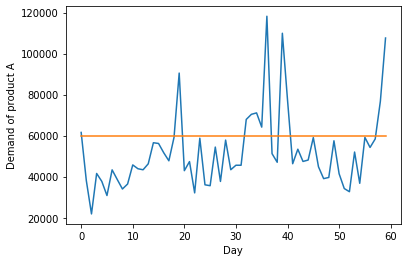

In [4]:
import numpy as np
plt.plot(frm['A'])
plt.plot(np.ones_like(frm['A'])*60000)
plt.xlabel('Day')
plt.ylabel('Demand of product A')

Y luego, podemos aplicar esta regla en el futuro. Vamos a usar este ejemplo para ilustrar lo que es modelizar. O mejor, dicho lo que no es: hemos tomado una decisión con los datos, pero no con una metodología, sino por prueba y error. 

Esta manera de seleccionar un valor es arbitraria y plantea algunos problemas. 

Por ejemplo, si ahora añadirmos la serie de productos B, 

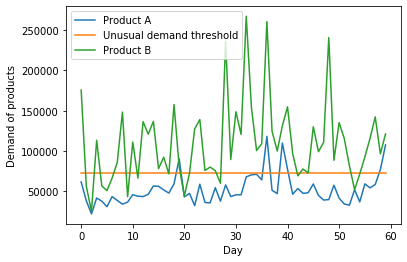

In [5]:
plt.plot(frm['A'])
plt.plot(np.ones_like(frm['A'])*73000)
plt.plot(frm['B'])
plt.xlabel('Day')
plt.ylabel('Demand of products')
plt.legend(['Product A', 'Unusual demand threshold', 'Product B'])

Según el criterio definido anteriormente, casi todos los días del producto B serían inusuales, porque están por encima del umbral que habíamos definido.  

¿Qué ha fallado? Vamos a destacar 2 puntos:

1. La regla para decidir si un valor de la demanda es inusual ha sido fijada a partir de los datos, pero manualmente por prueba y error. No ha sido *derivada* de los datos. En otra palabras, una vez definida, la regla es estática y no tiene capacidad de adaptarse a nuevos datos de la misma serie o de aplicarse a otras series. 

2. La regla no responde a un criterio que permite variarla razonadamente 

## Analítica con modelos

Modelizar se podría definir justamente como añadir una metodología para derivar una decisión a partir de los datos. 

Vamos a ver un ejemplo de **modelización** para resolver los dos problemas mencionados en la sección anterior. 

Para atacar el punto 2, primero, necesitamos una definición de qué significa "inusual". En matemáticas, existen formas de definir que una cantidad es inusual. Una  es calcular la media ($\mu$) y desviación estándar ($\sigma$) de los valores observados, y comprobar si el nuevo valor está fuera del rango  $\mu \pm k*\sigma$. Aquí $k$ es una constante y cuanto más alto, más inusual (pasamos rápido los detalles matemáticos: lo veremos en la clase de probabilidades). 

Definimos, pues, una función que toma un array de valores observados, un nuevo valor, y calcula $\mu$ y $\sigma$ y determina si un evento es inusual. 

In [6]:
def inusual(past, current, k=2.0):
    
    mu = np.mean(past)
    sig = np.std(past)
    
    # Sólo nos interesan los inusuales por exceso
    limit = k*sig + mu
    if current > limit:
        is_inusual = True
    else:
        is_inusual = False
        
    return is_inusual, limit

Imaginamos que aplicamos esta función a la serie del producto A, a partir del punto T=20

In [7]:
array_inusual = np.zeros_like(frm['A'], dtype=bool)
array_limit = np.zeros_like(frm['A'])

T = array_inusual.shape[0]
for i in range(20, T):
    
    array_inusual[i], array_limit[i] = inusual(frm['A'].values[:i], frm['A'].values[i])

In [8]:
array_inusual

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True])

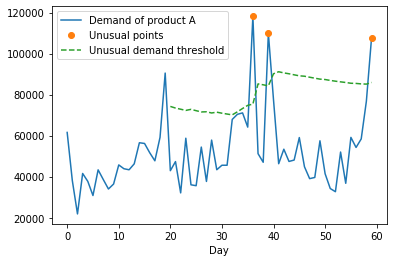

In [9]:
plt.plot(frm['A'])
idx = np.where(array_inusual)[0]
plt.plot(idx, frm['A'].values[array_inusual], 'o')
plt.plot(range(20, T), array_limit[20:], '--')
plt.xlabel('Day')
plt.legend(['Demand of product A', 'Unusual points', 'Unusual demand threshold'])


Si ahora aplicamos el mismo razonamiento al producto B

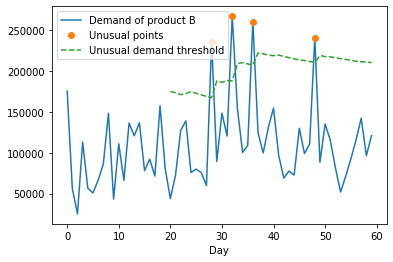

In [10]:
for i in range(20, array_inusual.shape[0]):
    
    array_inusual[i], array_limit[i] = inusual(frm['B'].values[:i], frm['B'].values[i])
    
plt.plot(frm['B'])
idx = np.where(array_inusual)[0]
plt.plot(idx, frm['B'].values[array_inusual], 'o')
plt.plot(range(20, T), array_limit[20:], '--')
plt.xlabel('Day')
plt.legend(['Demand of product B', 'Unusual points', 'Unusual demand threshold'])


En este caso, no hemos tenido que ajustar nada a mano. A partir de una definición de "inusual" cuantitativa, y de datos, se obtiene una decisión automática (y variable) de si la demanda de un día es inusual o no. Esto tiene las siguientes ventajas: 

* Se adapta a los datos (para decidir inusual / no en una nueva serie, se usa el mismo procedimiento). 
* Mejora conforme más datos se tienen. 
* Para tomar la decisión, no se requieren todos los datos, sólo $\mu$ y $\sigma$ (ojo!aquí tal como se ha escrito, sí, para no complicar el código, pero existen maneras. Lo importante a retener es que para tomar una decisión, en general, no se necesitan todos los datos cada vez que se tiene que tomar la decisión. 
* En este caso, pasamos ha ajustar k (el grado de "inusualidad", algo controlable) y el procedimiento se encarga de traducirlo al valor que haga falta. 

Estos 4 puntos son puntos clave en la modelización. 

Pero entonces, ¿qué es un modelo? En esta clase, vamos a considerar que es el procedimiento que da capacidad para tomar decisiones automáticamente a partir de los datos. Tiene 

* Un proceso de ajuste, donde se procesan los datos históricos
* Unos parámetros, que resumen el "estado de la situación" y cuyo valor se determina por el proceso de ajuste. 
* Un proceso de decisión, el cual usa los parámetros obtenidos para tomar decisiones en nuevos datos. 

Comentar que hay una suposicion de que nos fiamos del modelo estadístico (sí: los modelos también realizan unas suposiciones. En este caso, las suposiciones vienen dadas por la teoría de probabilidad. )

En el anterior ejemplo, el proceso de ajuste determina la $\mu$ y $\sigma$, que son los parámetros. El proceso de decisión es la regla $\mu + k*\sigma > x$. 

 

## Take-home messages  

* Se puede sacar valor de negocio sólo con datos (analítica descriptiva), por ejemplo tomar decisiones informadas. 
* Se pueden automatizar o asistir decisiones. Pero automatizar no implica modelar. 
* Modelizar es adoptar una metodología para automatizar la decisión basándonos en datos (en realidad también basándonos en suposiciones). Un modelo es una metodología concreta (hay muchas!)

* Un modelo tiene (i) un proceso de ajuste del modelo, (ii) unos parámetros y (iii) un proceso de aplicación del modelo al nuevo dato. Los parámetros son toda la información que se necesita para aplicar el modelo. 

**Para más ejemplos de ciencia de datos, ver [The Data Jiujitsu](http://www.oreilly.com/data/free/data-jujitsu.csp)
, de DJ Patil**. 
